In [103]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV
from tqdm import tqdm
import eli5
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from scipy.stats import loguniform
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [211]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")
df_test_y = pd.read_csv("../output/rfr21.csv").set_index('id')
df_test_y.index.name = None
df_test = df_test.join(df_test_y)

test_index = list(df_test.index)
train_index = list(df_train.index)

df_train.shape, df_test.shape

((26517, 3), (8735, 3))

In [212]:
def feature_engineering(df):
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofweek'] = df.date.dt.dayofweek
    df["weekofyear"] = df.date.dt.weekofyear
    df['day_name'] = df.date.dt.day_name()
    df['hour'] = df.date.dt.hour
    df['is_month_start'] = df.date.dt.is_month_start.astype(float)
    df['is_month_end'] = df.date.dt.is_month_end.astype(float)
    df['is_year_start'] = df.date.dt.is_year_start.astype(float)
    df['is_year_end'] = df.date.dt.is_year_end.astype(float)
    df['month_name'] = df.date.dt.month_name()
    df['quarter'] = df.date.dt.quarter
    return df

In [213]:
def make_shift(df):
#     df['lag_1'] = df['value'].shift(1)
#     df['lag_2'] = df['value'].shift(2)
#     df['lag_3'] = df['value'].shift(3)
#     df['lag_22'] = df['value'].shift(22)
    df['lag_23'] = df['value'].shift(23)
    df['lag_24'] = df['value'].shift(24)
    df['lag_25'] = df['value'].shift(25)
#     df['lag_26'] = df['value'].shift(26)
#     df['lag_m1'] = df['value'].shift(-1)
#     df['lag_m2'] = df['value'].shift(-2)
#     df['lag_m3'] = df['value'].shift(-3)
#     df['lag_m22'] = df['value'].shift(-22)
    df['lag_m23'] = df['value'].shift(-23)
    df['lag_m24'] = df['value'].shift(-24)
    df['lag_m25'] = df['value'].shift(-25)
#     df['lag_m26'] = df['value'].shift(-26)
    return df

In [214]:
df_full = pd.concat([df_train, df_test])
df_full = df_full.sort_values(by=['id'])

In [215]:
df_full = feature_engineering(df_full)

In [216]:
oneHotEncoder = OneHotEncoder()
X_ohe = oneHotEncoder.fit_transform(df_full[['dayofweek','month', 'year']])

ohe_labels = list(df_full.day_name.unique()[4:]) 
ohe_labels += list(df_full.day_name.unique()[:4])
ohe_labels += list(df_full.month_name.unique()[10:])  
ohe_labels += list(df_full.month_name.unique()[:10])
ohe_labels += list(df_full.year.unique().astype(np.str))

df_ohe = pd.DataFrame(X_ohe.toarray(), index=df_full.index, columns=ohe_labels)
df_full = df_full.join(df_ohe)

----------------------------

In [217]:
model = RandomForestRegressor(max_depth=20,n_estimators=500,n_jobs = -1,random_state=42)
test_model_again(model) #237, 226, 217, 213

5it [05:39, 67.91s/it]

213.95174646623954 4.254994416378001


-------------------

In [222]:
for i in range (50,61):
    print(f'i={i}, max_depth={70-i}')
    df_train = pd.read_hdf("../input/energy_train.h5")
    df_test = pd.read_hdf("../input/energy_test.h5")
    df_test_y = pd.read_csv(f"../output/rfr{i}.csv").set_index('id')
    df_test_y.index.name = None
    df_test = df_test.join(df_test_y)

    test_index = list(df_test.index)
    train_index = list(df_train.index)

    df_train.shape, df_test.shape

    df_full = pd.concat([df_train, df_test])
    df_full = df_full.sort_values(by=['id'])
    df_full = feature_engineering(df_full)

    oneHotEncoder = OneHotEncoder()
    X_ohe = oneHotEncoder.fit_transform(df_full[['dayofweek','month', 'year']])

    ohe_labels = list(df_full.day_name.unique()[4:]) 
    ohe_labels += list(df_full.day_name.unique()[:4])
    ohe_labels += list(df_full.month_name.unique()[10:])  
    ohe_labels += list(df_full.month_name.unique()[:10])
    ohe_labels += list(df_full.year.unique().astype(np.str))

    df_ohe = pd.DataFrame(X_ohe.toarray(), index=df_full.index, columns=ohe_labels)
    df_full = df_full.join(df_ohe)

    model = RandomForestRegressor(max_depth=70-i,n_estimators=500,n_jobs = -1,random_state=42)
    y_test_pred = train_full_and_predict(df_full, train_columns, model)

    df_out = pd.DataFrame(data=y_test_pred, index=test_index, columns=['value'])
    df_out.index.name = 'id'
    df_out.to_csv(f"../output/rfr{i+1}.csv")

i=50, max_depth=20
103.05019618463506
i=51, max_depth=19
107.82743182061154
i=52, max_depth=18
115.10616495707382
i=53, max_depth=17
123.93551830919145
i=54, max_depth=16
134.42311185771547
i=55, max_depth=15
147.31881177456282
i=56, max_depth=14
163.10626890552786
i=57, max_depth=13
181.40294971109813
i=58, max_depth=12
204.1159688303685
i=59, max_depth=11
229.27305836590145
i=60, max_depth=10
260.33969939109625


-----------------------------------------------

In [178]:
df_full.columns

Index(['id', 'date', 'value', 'day', 'month', 'year', 'dayofweek',
       'weekofyear', 'day_name', 'hour', 'is_month_start', 'is_month_end',
       'is_year_start', 'is_year_end', 'month_name', 'quarter', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', '2018',
       '2019', '2020', '2021', '2022'],
      dtype='object')

In [179]:
train_columns = ['hour', 'is_month_start',   'is_month_end',  'is_year_start',
                 'is_year_end','weekofyear', 'quarter','Monday','Tuesday','Wednesday', 
                 'Thursday','Friday','Saturday','Sunday','January','February',
                 'March','April','May','June','July','August','September','October',
                 'November','December','2018','2019','2020','2021','2022', 
                 'lag_23', 'lag_24', 'lag_25', 'lag_m23', 'lag_m24', 'lag_m25'
                ]

# Fill NaN in value

In [149]:
df_full['value_ffill'] = df_full['value'].fillna(method='ffill')
df_full['value_bfill'] = df_full['value'].fillna(method='bfill')
df_full['value_rolling_3'] = df_full['value'].rolling(window=3).mean()
df_full['value_rolling_8'] = df_full['value'].rolling(window=8).mean()
df_full['value_rolling_24'] = df_full['value'].rolling(window=24).mean()
df_full['value_rolling_168'] = df_full['value'].rolling(window=168).mean()

In [176]:
mean_month_value = np.zeros(df_full.shape[0])
for month in df_full.month.unique():
    mean_value = df_full[df_full.month==month].value.mean()
    mean_month_value[list(df_full[df_full.month==month].index)] = mean_value
df_full['mean_month_value'] = mean_month_value

mean_year_value = np.zeros(df_full.shape[0])
for year in df_full.year.unique():
    mean_value = df_full[df_full.year==year].value.mean()
    mean_year_value[list(df_full[df_full.year==year].index)] = mean_value
df_full['mean_year_value'] = mean_year_value

mean_dayofweek_value = np.zeros(df_full.shape[0])
for dayofweek in df_full.dayofweek.unique():
    mean_value = df_full[df_full.dayofweek==dayofweek].value.mean()
    mean_dayofweek_value[list(df_full[df_full.dayofweek==dayofweek].index)] = mean_value
df_full['mean_dayofweek_value'] = mean_dayofweek_value

mean_hour_value = np.zeros(df_full.shape[0])
for hour in df_full.hour.unique():
    mean_value = df_full[df_full.hour==hour].value.mean()
    mean_hour_value[list(df_full[df_full.hour==hour].index)] = mean_value
df_full['mean_hour_value'] = mean_hour_value

mean_quarter_value = np.zeros(df_full.shape[0])
for quarter in df_full.quarter.unique():
    mean_value = df_full[df_full.quarter==quarter].value.mean()
    mean_quarter_value[list(df_full[df_full.quarter==quarter].index)] = mean_value
df_full['mean_quarter_value'] = mean_quarter_value

In [180]:
test_y_mean = df_full[['value_ffill','value_bfill','value_rolling_3','value_rolling_8',
                       'value_rolling_24','value_rolling_168',
                       'mean_month_value', 'mean_year_value', 'mean_dayofweek_value', 
                       'mean_hour_value', 'mean_quarter_value']
                     ].mean(axis=1)[test_index]

In [192]:
df_out = pd.DataFrame(data=test_y_mean, columns=['value'])
df_out.index.name = 'id'
df_out.to_csv("../output/just_mean.csv")

In [184]:
df_full.iloc[test_index, df_full.columns.get_loc('value')] = test_y_mean

# Test and experimetns

In [120]:
def test_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    X_train = df_full.iloc[train_index]
    X_test = df_full.iloc[test_index]
    start_day = np.where(np.arange(len(train_index))%24 == 0)[0]

    for train_idx, test_idx in tqdm(cv.split(start_day)):

        test_id = []
        for start_h in start_day[test_idx]:
            for i in range(24):
                test_id.append(start_h+i)
        if 26517 in test_id: test_id.remove(26517)
        if 26518 in test_id: test_id.remove(26518)
        if 26519 in test_id: test_id.remove(26519)

        train_id = []
        for start_h in start_day[train_idx]:
            for i in range(24):
                train_id.append(start_h+i)
        if 26517 in train_id: train_id.remove(26517)
        if 26518 in train_id: train_id.remove(26518)
        if 26519 in train_id: train_id.remove(26519)

        test_value_change = X_train.iloc[train_id].value.mean()
        lag_value_change = X_train.iloc[train_id].value.mean()

        X_change = X_train.copy()
        y_train_tmp, y_test_tmp = X_change.iloc[train_id].value, X_change.iloc[test_id].value
#         X_change.iloc[test_id, X_change.columns.get_loc('value')] = test_value_change
        X_change = make_shift(X_change)
        X_change = X_change.fillna(lag_value_change)
        X_train_tmp, X_test_tmp = X_change.iloc[train_id][train_columns], X_change.iloc[test_id][train_columns]
        
        model.fit(X_train_tmp, y_train_tmp)
        y_pred = model.predict(X_test_tmp)
        score = mae(y_test_tmp, y_pred)
        scores.append(score)

    print(np.mean(scores), np.std(scores))

In [122]:
def test_model_again(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    start_day = np.where(np.arange(len(train_index))%24 == 0)[0]

    for train_id, test_id in tqdm(cv.split(df_full)):
        lag_value_change = df_full.iloc[train_id].value.mean()
        X_change = df_full.copy()
        y_train_tmp, y_test_tmp = X_change.iloc[train_id].value, X_change.iloc[test_id].value
        X_change = make_shift(X_change)
        X_change = X_change.fillna(lag_value_change)
        X_train_tmp, X_test_tmp = X_change.iloc[train_id][train_columns], X_change.iloc[test_id][train_columns]
        
        model.fit(X_train_tmp, y_train_tmp)
        y_pred = model.predict(X_test_tmp)
        score = mae(y_test_tmp, y_pred)
        scores.append(score)

    print(np.mean(scores), np.std(scores))

In [79]:
# 530 GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=100, random_state=42)
# 504 GradientBoostingRegressor(learning_rate=0.2, max_depth=6, n_estimators=100, random_state=42)
# 492 GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 497 GradientBoostingRegressor(learning_rate=0.2, max_depth=8, n_estimators=100, random_state=42)
# 504 GradientBoostingRegressor(learning_rate=0.2, max_depth=9, n_estimators=100, random_state=42)

In [80]:
# 495 GradientBoostingRegressor(max_leaf_nodes=100, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 494 GradientBoostingRegressor(max_leaf_nodes=250, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 494 GradientBoostingRegressor(max_leaf_nodes=500, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 494 GradientBoostingRegressor(max_leaf_nodes=1000, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 492 GradientBoostingRegressor(max_leaf_nodes=None, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)

In [180]:
# 457 model = GradientBoostingRegressor(max_leaf_nodes=None, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42)
# 446 model = RandomForestRegressor(max_depth=20,n_estimators=500,n_jobs = -1,random_state=42)
model = RandomForestRegressor(max_depth=20,n_estimators=500,n_jobs = -1,random_state=42)
test_model_again(model) #237, 226, 217

5it [05:42, 68.54s/it]

217.75255601554272 4.687451295137632


In [124]:
eli5.show_weights(model, feature_names=train_columns, top=7)

In [125]:
def train_full_and_predict(df_full, train_columns, model, new_test_value=None):
#     if new_test_value is None:
    test_value_change = df_full.value.mean()
    lag_value_change = df_full.value.mean()
    
    X_change = df_full.copy()
    X_change = X_change.fillna(test_value_change)
    X_change = make_shift(X_change)
    X_change = X_change.fillna(lag_value_change)
    
    df_train = X_change.iloc[train_index]
    df_test  = X_change.iloc[test_index]
    
    X_train = df_train[train_columns]
    y_train = df_train["value"]
    X_test  = df_test[train_columns]
    
    model.fit(X_train, y_train)
    print(mae(y_train, model.predict(X_train)))
    
    return model.predict(X_test)

In [181]:
model = RandomForestRegressor(max_depth=20,n_estimators=500,n_jobs = -1,random_state=42)
y_test_pred = train_full_and_predict(df_full, train_columns, model)

103.76853736343237


In [182]:
df_out = pd.DataFrame(data=y_test_pred, index=test_index, columns=['value'])
df_out.index.name = 'id'
df_out.to_csv("../output/rfr16.csv")

In [196]:
model = GradientBoostingRegressor(max_leaf_nodes=None, learning_rate=0.2, max_depth=7, n_estimators=500, random_state=42)
y_test_pred = train_full_and_predict(df_full, train_columns, model)

75.24026147578127


In [197]:
df_out = pd.DataFrame(data=y_test_pred, index=test_index, columns=['value'])
df_out.index.name = 'id'
df_out.to_csv("../output/gbr2.csv")

# Pandas Profiling

In [68]:
test_value_change = df_full.value.mean()
lag_value_change = df_full.value.mean()

X_change = df_full.copy()
X_change = X_change.fillna(test_value_change)
X_change = make_shift(X_change)
X_change = X_change.fillna(lag_value_change)

df_train = X_change.iloc[train_index]
df_test  = X_change.iloc[test_index]

X_train = df_train[train_columns]
    
profile = ProfileReport(df_train)
profile.to_file("../output/profile.html")

Summarize dataset:   0%|          | 0/64 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

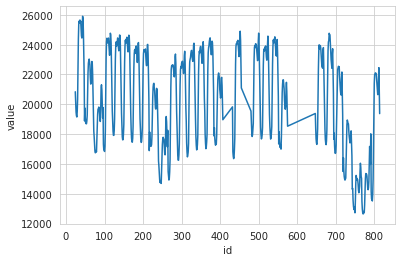

In [95]:
sns.lineplot(data=df_train.iloc[:24*7*4], x="id", y="value");

# Sunday

In [12]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [13]:
X_train = df_full.iloc[train_index]
X_test = df_full.iloc[test_index]

In [14]:
X_train = make_shift(X_train)

In [15]:
X_train = X_train[train_columns]

In [16]:
y = df_full.iloc[train_index][['value']]
y  = y.set_index(df_full.iloc[train_index].date)
y = y.resample('MS').mean()

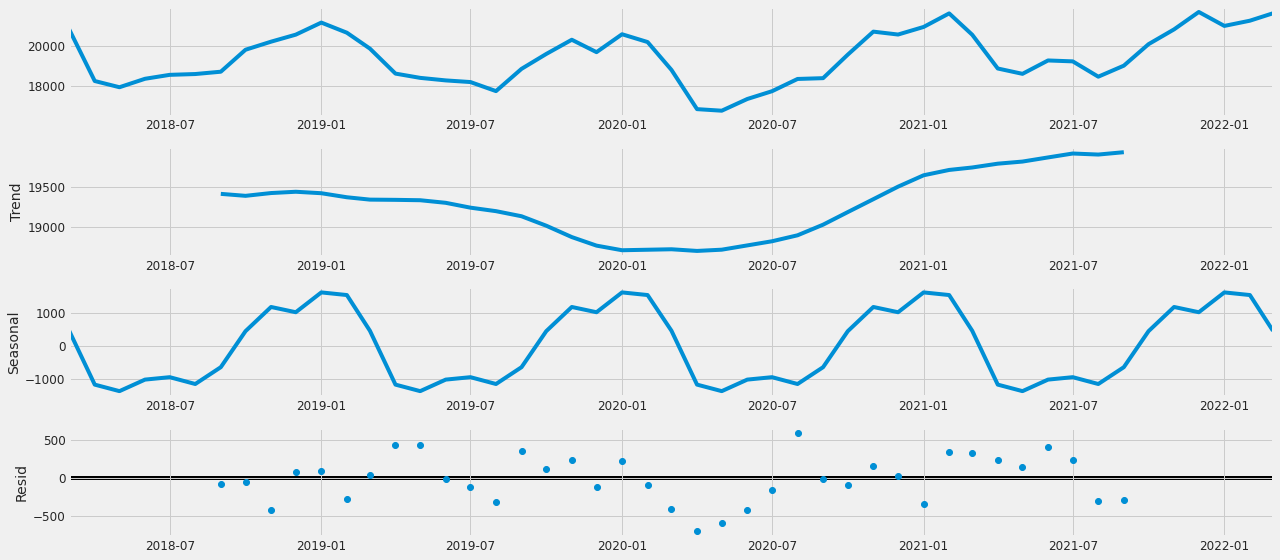

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## ARIMA

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1086.1853389495282
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:793.0165753467154
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:599.3336989371319


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:789.9701002301294
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:617.0009864478627
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:596.0213048888235
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:419.9261002667128
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:402.05835430361986
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1032.5806007926126
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:765.1464296978918
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:568.6620663470331


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:991.8228868444695
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:837.4820764977846
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:567.1709736369181
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:412.20414670468716
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:378.52245861060527
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:758.3509015336223
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:968.4869386753719


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:557.0868425847959
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:363.69872953713747
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:568.9807239715709


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1320.7514780424062
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:382.6897332220098
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:365.4931789865635
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:737.7238313884216


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2529.1342781778817
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:541.8953842876151
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:348.65414412226846
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:569.8447345237021


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2622.304490521759
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:384.07365091936157
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:350.4080805725376
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:785.998255439772
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:634.369016736885
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:572.8256235311712


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:965.0612249069694
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:570.8901264537865
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:572.6948550349355
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:382.469468887674
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:381.13213179815114
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:754.603718490786
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:564.2842036576121
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:556.3914278195384


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:662.3399108415261
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:571.7989887783422
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:559.9767009487365
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:384.4769839492637
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:365.12677503535707
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:754.6240342264431


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1262.468772677833
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:557.4530317185756
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:364.17634024792113
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:555.3678062806789


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1514.3148271543241
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:368.36446081108954
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:366.034819525
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:739.5144996650257
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:927.628624393521
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:543.8799282682415
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:350.42495054668996
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:556.724522955262


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:847.3354868041105
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:367.01516438860295
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:350.68641289462465


In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2459      0.190     -1.294      0.196      -0.618       0.127
ma.S.L12      -0.0306      0.099     -0.310      0.757      -0.224       0.163
sigma2      4.483e+05   1.38e+05      3.245      0.001    1.78e+05    7.19e+05


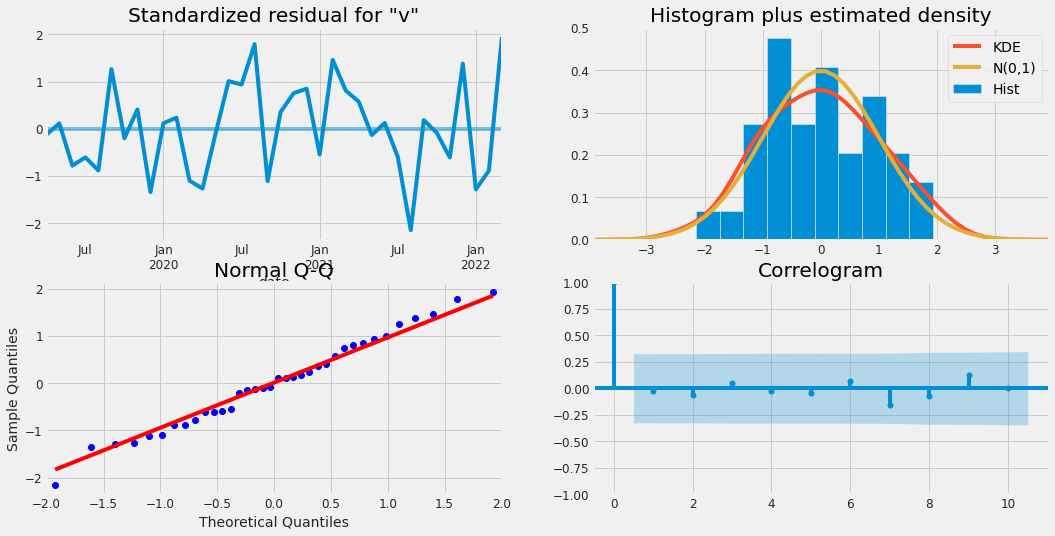

In [24]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [27]:
pred

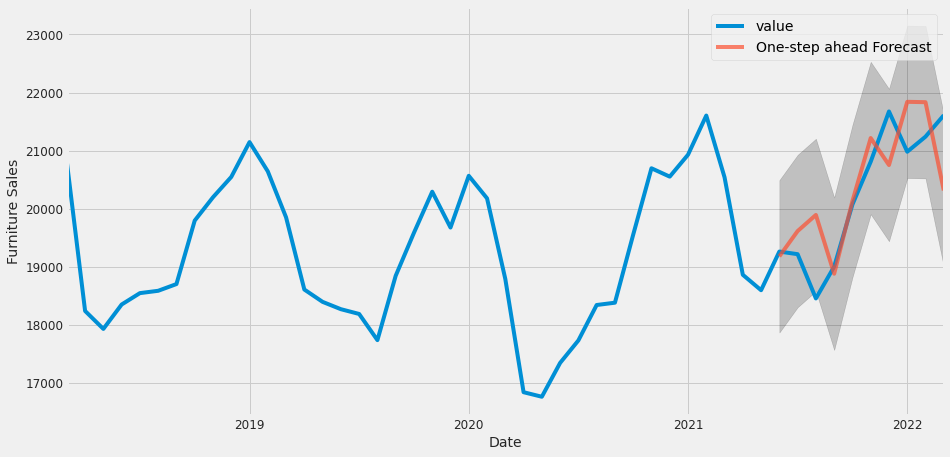

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [44]:
y_forecasted = pred.predicted_mean
y_truth = y['2021-06-01':]
mse = ((y_forecasted - y_truth.value) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
mae_value = mae(y_truth.value, y_forecasted )
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae_value, 2)))

The Mean Squared Error of our forecasts is 603563.34
The Root Mean Squared Error of our forecasts is 776.89
The Mean Absolute Error of our forecasts is 617.71


## Prophet

In [45]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [49]:
y = df_full.iloc[train_index][['value']]
# y = y.set_index(df_full.iloc[train_index].date)
y['date'] = df_full.iloc[train_index].date
y.sample(3)

,value,date
18702,16261.575,2020-04-18 09:00:00
10811,19111.600,2019-05-25 13:00:00
23527,23271.625,2020-11-05 10:00:00


In [53]:
df = y.rename(columns={'date': 'ds','value': 'y'})
df.head(5)

,y,ds
24,20842.538,2018-03-02 00:00:00
25,20108.125,2018-03-02 01:00:00
26,19480.463,2018-03-02 02:00:00
27,19235.275,2018-03-02 03:00:00
28,19149.388,2018-03-02 04:00:00


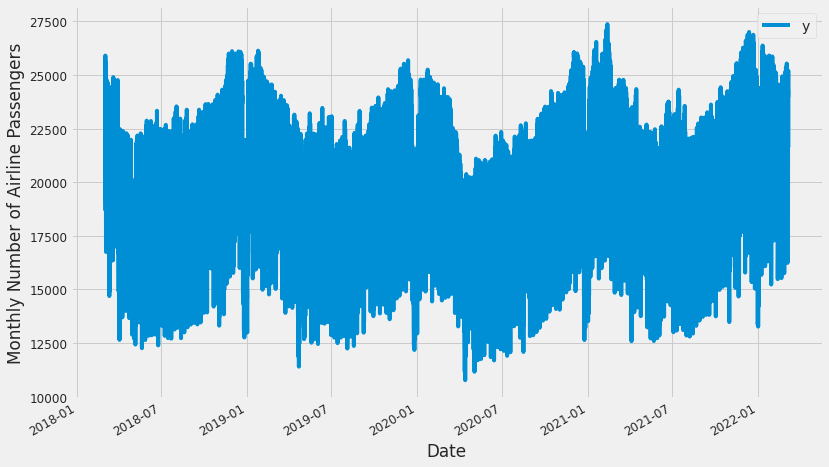

In [54]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [55]:
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

In [68]:
future_dates = my_model.make_future_dataframe(periods=24, freq='H')
future_dates.tail()

,ds
26536,2022-03-08 19:00:00
26537,2022-03-08 20:00:00
26538,2022-03-08 21:00:00
26539,2022-03-08 22:00:00
26540,2022-03-08 23:00:00


In [91]:
df_full.iloc[test_index][['date']].rename(columns={'date':'ds'}).sample(3)

,ds
19552,2020-05-23 19:00:00
13084,2019-08-28 06:00:00
19677,2020-05-29 00:00:00


In [92]:
forecast = my_model.predict(df_full.iloc[test_index][['date']].rename(columns={'date':'ds'}))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8730,2022-03-08 19:00:00,23836.246255,21423.527841,26286.100460
8731,2022-03-08 20:00:00,23995.594859,21599.342020,26569.060824
8732,2022-03-08 21:00:00,23652.900367,21200.390902,26069.548631
8733,2022-03-08 22:00:00,22700.128590,20270.676164,25231.574677
8734,2022-03-08 23:00:00,21392.965462,18561.999208,23928.462424


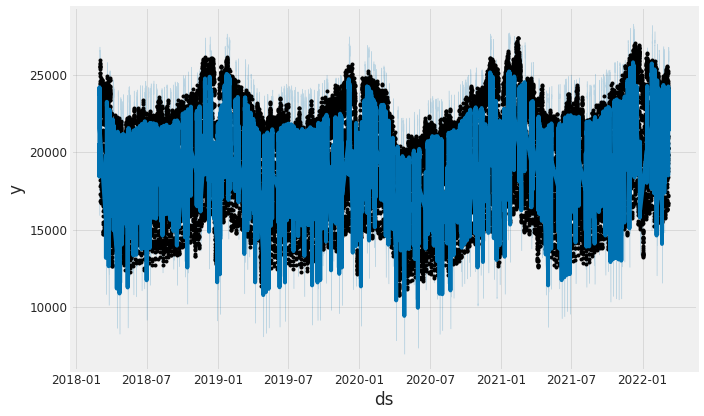

In [93]:
my_model.plot(forecast, uncertainty=True);

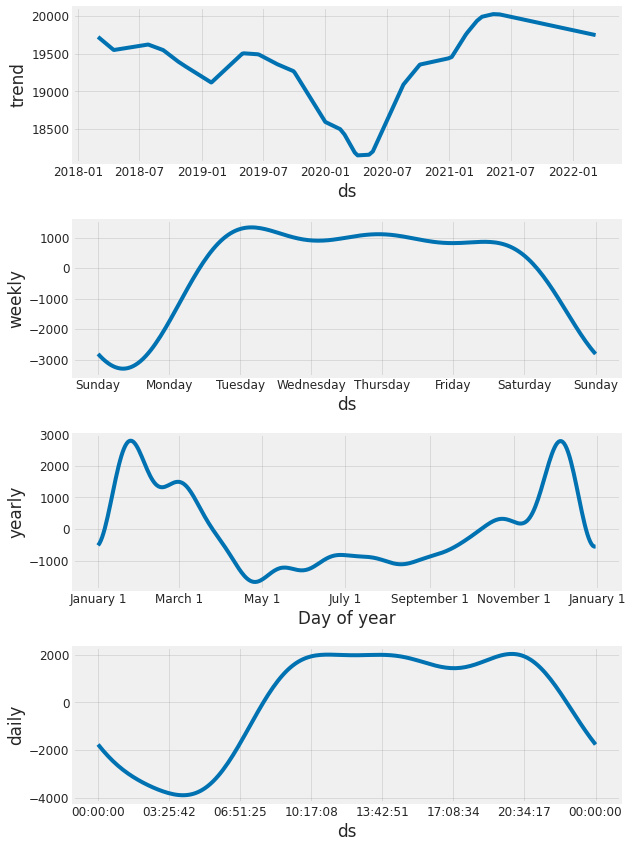

In [94]:
my_model.plot_components(forecast);

In [102]:
df_out = forecast[['yhat']]
df_out = df_out.rename(columns={'yhat':'value'})
df_out['id'] = test_index
df_out = df_out.set_index('id')
df_out.to_csv("../output/prophet1.csv")